In [1]:
using DrWatson
quickactivate(@__DIR__)

using NetHeider
using LinearAlgebra
using LightGraphs
using Plots, Measures
using DataFrames
using JLD2
using Statistics

include(projectdir("scripts", "notebook_res_anal_funs.jl"))

show_res (generic function with 1 method)

In [2]:
res = jldopen(datadir("sims8", "collected_results.jld2")) do file
    file["res"]
end
first(res, 10)

,inform_every,add_edges,m_filename,pr_neg,padd,measure_balance_every_step
,Float64?,#add_sin…?,String?,Float64?,Float64?,Int64?
1,0.25,add_single_edge2!,results.csv,0.05,0.01,5
2,0.25,add_single_edge2!,results.csv,0.15,0.01,5
3,0.25,add_single_edge2!,results.csv,0.1,0.01,5
4,0.25,add_single_edge2!,results.csv,0.25,0.01,5
5,0.25,add_single_edge2!,results.csv,0.2,0.01,5
6,0.25,add_single_edge2!,results.csv,0.3,0.01,5
7,0.25,add_single_edge2!,results.csv,0.05,0.03,5
8,0.25,add_single_edge2!,results.csv,0.15,0.03,5
9,0.25,add_single_edge2!,results.csv,0.1,0.03,5


In [3]:
names(res)

40-element Vector{String}:
 "inform_every"
 "add_edges"
 "m_filename"
 "pr_neg"
 "padd"
 "measure_balance_every_step"
 "bal2not_mean2"
 "net_str"
 "balanced_std"
 "N"
 ⋮
 "unbal2bal_mean2"
 "triads_num"
 "last_val"
 "unbal2bal_mean"
 "attr"
 "pn"
 "save_after"
 "bal2bal_mean2"
 "path"

## Assuming pn=0.4

In [4]:
fname = datadir("exp_pro", "sims8_withT_allT.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end

,padd,pr_neg,pn,pclose_triad,pr_pos,dict_ind,time_ind,mse,mae
,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,0.01,0.05,0.4,0.0,0.05,1,1.0,5.63912,9.64983
2,0.01,0.05,0.4,0.0,0.05,1,2.0,4.7075,8.47637
3,0.01,0.05,0.4,0.0,0.05,1,3.0,4.15379,7.67876


false

In [5]:
# parameters
pn = [0.4]
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_points = [5:5:400...]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

if calc_errors
    x = dicts[1]
    results_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
    results_df.dict_ind = [0]
    results_df.time_ind = [0.]
    results_df.mse = [0.]
    results_df.mae = [0.]
    results_df.mse_notbeg = [0.]
    results_df.mae_notbeg = [0.]
    delete!(results_df, 1)

    for (dict_ind, dict) in enumerate(dicts)   
        if dict["pr_pos"] != dict["pr_neg"]
            continue
        end
        
        cropped_res = get_part_dataframe(res, dict; verbose =false)
        if nrow(cropped_res) == 0
            display(dict)
        end
        for (i, time_ind) in enumerate(time_inds)
            xvals = cropped_res[:, :threshold]
            b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
            u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

            #sorting, just in case
            inds = sortperm(xvals)
            xvals = xvals[inds]
            b2b_vals = b2b_vals[inds]
            u2b_vals = u2b_vals[inds]

            @assert xvals == real_trans_df.threshold

            mse = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
            mae = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
            mse_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
            mae_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

            x = dict
            temp_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
            temp_df.dict_ind = [dict_ind]
            temp_df.time_ind = [time_ind]
            temp_df.mse = [mse]
            temp_df.mae = [mae]
            temp_df.mse_notbeg = [mse_notbeg]
            temp_df.mae_notbeg = [mae_notbeg]
            
            append!(results_df, temp_df)
        end
    end


    jldopen(fname, "w") do file
        file["res"] = results_df
    end;
end

In [6]:
#finding 10 best param sets

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg, :mse_manyT, :mae_manyT]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = results_df[inds2, col]
end
mulinds


6×10 Matrix{Int64}:
 275  270  271  276  273  272  274   277  189   269
  21   22  262  270  265  189  188   261  271   266
 276  275  277  279  274  273  272   278   38   280
 190  271  270  189  273  269  272    22   26   191
 655  814  656  815  816  255  817  1135  813  1134
 176  814  173  255  172  256  815   175  973   252

In [7]:
valinds

6×10 Matrix{Float64}:
 1.69416   1.69653   1.69688   1.69863   …  1.72376   1.72999   1.73144
 4.52041   4.53055   4.55518   4.57328      4.58433   4.5849    4.5894
 0.795157  0.810165  0.811251  0.818263     0.831779  0.835243  0.837516
 2.83641   2.84049   2.86276   2.87851      2.88985   2.89292   2.89825
 0.234756  0.23993   0.240473  0.241927     0.252074  0.253163  0.253242
 1.80381   1.81091   1.81198   1.81655   …  1.82886   1.83025   1.83133

In [8]:
results_df[655, :mae_manyT]

1.8393476560476796

In [9]:
show_res(results_df, dicts, 814)
show_res(results_df, dicts, 176)
show_res(results_df, dicts, 655)
show_res(results_df, dicts, 815)
show_res(results_df, dicts, 173)
show_res(results_df, dicts, 255)


"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.1, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.1)"

"70.0"

"Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"80.0"

"Dict(\"padd\" => 0.07, \"pr_neg\" => 0.15, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.15)"

"75.0"

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.1, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.1)"

"75.0"

"Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"65.0"

"Dict(\"padd\" => 0.07, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"75.0"

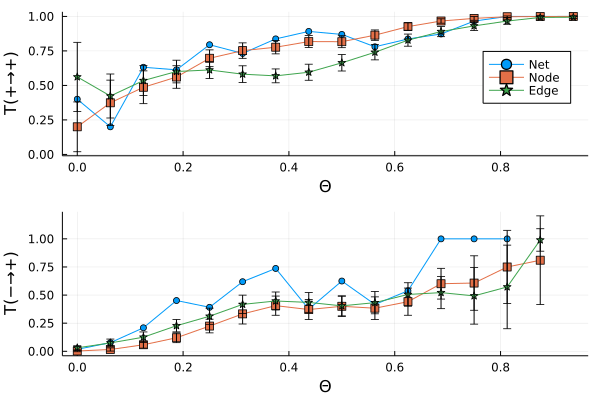

In [10]:
real_trans_df = jldopen(datadir("exp_pro", "real_randomized_triad_trans_results.jld2")) do file
    file["res"]
end

xvals = real_trans_df.threshold
p1 = plot(xvals, real_trans_df.netsense_b2b, 
    markershape = :circle, label = "Net", legend = :right)#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_b2b, yerror = real_trans_df.node_rand_b2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_b2b, yerror = real_trans_df.edge_rand_b2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)

markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
p2 = plot(legend = false)

plot!(xvals, real_trans_df.netsense_u2b, 
    markershape = :circle, label = "Net")#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_u2b, yerror = real_trans_df.node_rand_u2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_u2b, yerror = real_trans_df.edge_rand_u2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)


ylabel!("T(−→+)")

plot(p1, p2, layout = (2,1))
xlabel!("Θ")

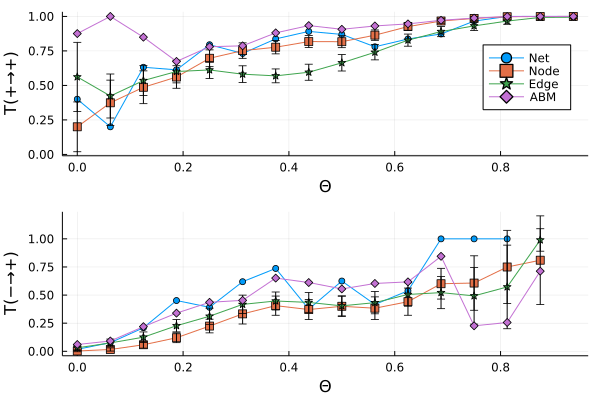

In [11]:
# parameters
pn = 0.4
pclose_triad = 0.
pr_pos = pr_neg = 0.15
padd = 0.07
threshold = [0:15...]/16

time_step = 75
time_ind = Int(time_step / 5)

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

# L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

xvals = real_trans_df.threshold
p1 = plot(xvals, real_trans_df.netsense_b2b, 
    markershape = :circle, label = "Net", legend = :right)#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_b2b, yerror = real_trans_df.node_rand_b2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_b2b, yerror = real_trans_df.edge_rand_b2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)
plot!(xvals, b2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)

markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
p2 = plot(legend = false)

plot!(xvals, real_trans_df.netsense_u2b, 
    markershape = :circle, label = "Net")#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_u2b, yerror = real_trans_df.node_rand_u2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_u2b, yerror = real_trans_df.edge_rand_u2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)
plot!(xvals, u2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)


ylabel!("T(−→+)")

plot(p1, p2, layout = (2,1))
xlabel!("Θ")

# title!("pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01")

In [34]:
# parameters
pn = 0.4
pclose_triad = 0.
pr_pos = pr_neg = 0.15
padd = 0.07
threshold = [0:15...]/16

time_step = 75
time_ind = Int(time_step / 5)

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

xvals = real_trans_df.threshold
p1 = plot(xvals, real_trans_df.netsense_b2b, 
    markershape = :circle, label = "Data", legend = :right)#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_b2b, linestyle = :dash, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_b2b, linestyle = :dot, label = "Edge")#, linestyle = :none)
plot!(xvals, b2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)

# plot!([0.4, 0.7], [0.5, 0.8], markershape = :diamond, markersize = 2, label = "fff")
markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
ylabel!("T(b→b)")
xlabel!("Θ")
p2 = plot(legend = false)

plot!(xvals, real_trans_df.netsense_u2b, 
    markershape = :circle, label = "Data")#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_u2b, linestyle = :dash, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_u2b, linestyle = :dot, label = "Edge")#, linestyle = :none)
plot!(xvals, u2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)


ylabel!("T(−→+)")
ylabel!("T(u→b)")
Plots.scalefontsizes()
# Plots.scalefontsizes(1.3)

pall = plot(p2, p1, layout = (2,1), left_margins = 2mm)#, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18, legendfontsize = 10,  thickness_scaling=1) 
plot!(windowsize = (400,600))
# plot!(margins = 2.0)


# title!("pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01")

# savefig(pall, "ABM_result.pdf")
safesave(
        projectdir("plots", savename("ABM_result_sims8", dict, "pdf")),
        pall
    )
    safesave(
        projectdir("plots", "ABM_result_sims8.pdf"),
        pall
    )

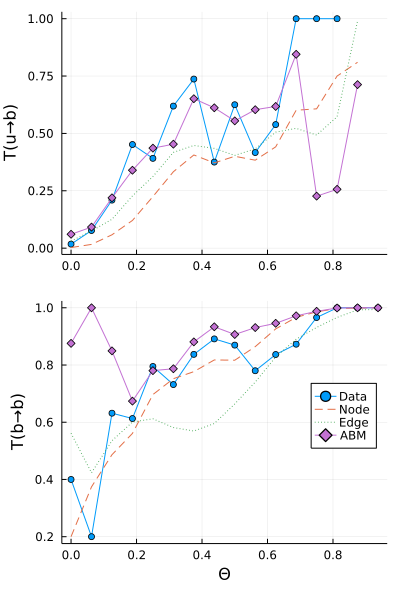

In [35]:
pall

In [32]:
# parameters
pn = 0.4
pclose_triad = 0.
pr_pos = pr_neg = 0.15
padd = 0.07
threshold = [0:15...]/16

time_step = 75
time_ind = Int(time_step / 5)

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

xvals = real_trans_df.threshold
p1 = plot(xvals[4:end], real_trans_df.netsense_b2b[4:end], 
    markershape = :circle, label = "Data", legend = :right)#, linestyle = :none)

plot!(xvals[4:end], real_trans_df.node_rand_b2b[4:end], linestyle = :dash, label = "Node")#, linestyle = :none)
plot!(xvals[4:end], real_trans_df.edge_rand_b2b[4:end], linestyle = :dot, label = "Edge")#, linestyle = :none)
plot!(xvals[4:end], b2b_vals[4:end], markershape = :diamond, label = "ABM")#, linestyle = :none)

trans = 0.4

plot!(xvals[1:4], real_trans_df.netsense_b2b[1:4], 
    markershape = :circle, label = false, linealpha = trans, markeralpha = trans, color = 1)#, linestyle = :none)

plot!(xvals[1:4], real_trans_df.node_rand_b2b[1:4], linestyle = :dash, label = false, linealpha = trans, markeralpha = trans, color = 2)#, linestyle = :none)
plot!(xvals[1:4], real_trans_df.edge_rand_b2b[1:4], linestyle = :dot, label = false, linealpha = trans, markeralpha = trans, color = 3)#, linestyle = :none)
plot!(xvals[1:4], b2b_vals[1:4], markershape = :diamond, label = false, linealpha = trans, markeralpha = trans, color = 4)#, linestyle = :none)

# plot!([0.4, 0.7], [0.5, 0.8], markershape = :diamond, markersize = 2, label = "fff")
markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
ylabel!("T(b→b)")
xlabel!("Θ")
p2 = plot(legend = false)

plot!(xvals[1:12], real_trans_df.netsense_u2b[1:12], 
    markershape = :circle, label = "Data")#, linestyle = :none)

plot!(xvals[1:12], real_trans_df.node_rand_u2b[1:12], linestyle = :dash, label = "Node")#, linestyle = :none)
plot!(xvals[1:12], real_trans_df.edge_rand_u2b[1:12], linestyle = :dot, label = "Edge")#, linestyle = :none)
plot!(xvals[1:12], u2b_vals[1:12], markershape = :diamond, label = "ABM")#, linestyle = :none)


plot!(xvals[12:end], real_trans_df.netsense_u2b[12:end], 
    markershape = :circle, label = false, linealpha = trans, markeralpha = trans, color = 1)#, linestyle = :none)

plot!(xvals[12:end], real_trans_df.node_rand_u2b[12:end], linestyle = :dash, label = false, linealpha = trans, markeralpha = trans, color = 2)#, linestyle = :none)
plot!(xvals[12:end], real_trans_df.edge_rand_u2b[12:end], linestyle = :dot, label = false, linealpha = trans, markeralpha = trans, color = 3)#, linestyle = :none)
plot!(xvals[12:end], u2b_vals[12:end], markershape = :diamond, label = false, linealpha = trans, markeralpha = trans, color = 4)#, linestyle = :none)


ylabel!("T(−→+)")
ylabel!("T(u→b)")
Plots.scalefontsizes()
# Plots.scalefontsizes(1.3)

pall = plot(p2, p1, layout = (2,1), left_margins = 2mm)#, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18, legendfontsize = 10,  thickness_scaling=1) 
plot!(windowsize = (400,600))
# plot!(margins = 2.0)


# title!("pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01")

# savefig(pall, "ABM_result.pdf")
safesave(
        projectdir("plots", savename("ABM_result_sims8", dict, "pdf")),
        pall
    )
    safesave(
        projectdir("plots", "ABM_result_sims_shaded8.pdf"),
        pall
    )

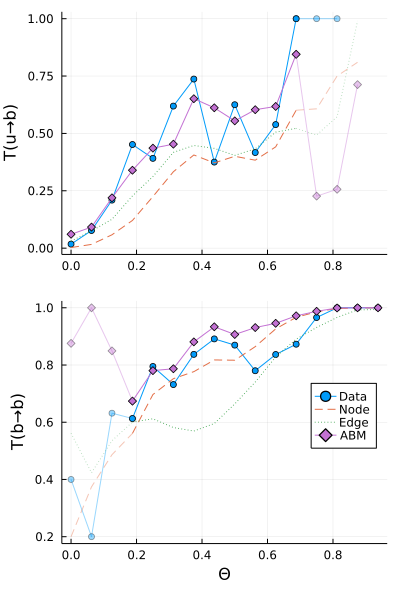

In [33]:
pall

In [38]:
# parameters
pn = 0.4
pclose_triad = 0.
pr_pos = pr_neg = 0.15
padd = 0.07
threshold = [0:15...]/16

time_step = 75
time_ind = Int(time_step / 5)

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

xvals = real_trans_df.threshold
p1 = plot(xvals[1:end], real_trans_df.netsense_b2b[1:end], 
    markershape = :circle, label = "Data", legend = :right)#, linestyle = :none)

plot!(xvals[1:end], real_trans_df.node_rand_b2b[1:end], linestyle = :dash, label = "Node")#, linestyle = :none)
plot!(xvals[1:end], real_trans_df.edge_rand_b2b[1:end], linestyle = :dot, label = "Edge")#, linestyle = :none)
plot!(xvals[4:end], b2b_vals[4:end], markershape = :diamond, label = "ABM")#, linestyle = :none)

trans = 0.4

# plot!(xvals[1:4], real_trans_df.netsense_b2b[1:4], 
#     markershape = :circle, label = false, linealpha = trans, markeralpha = trans, color = 1)#, linestyle = :none)

# plot!(xvals[1:4], real_trans_df.node_rand_b2b[1:4], linestyle = :dash, label = false, linealpha = trans, markeralpha = trans, color = 2)#, linestyle = :none)
# plot!(xvals[1:4], real_trans_df.edge_rand_b2b[1:4], linestyle = :dot, label = false, linealpha = trans, markeralpha = trans, color = 3)#, linestyle = :none)
plot!(xvals[1:4], b2b_vals[1:4], markershape = :diamond, label = false, linealpha = trans, markeralpha = trans, color = 4)#, linestyle = :none)

# plot!([0.4, 0.7], [0.5, 0.8], markershape = :diamond, markersize = 2, label = "fff")
markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
ylabel!("T(b→b)")
xlabel!("Θ")
p2 = plot(legend = false)

plot!(xvals[1:end], real_trans_df.netsense_u2b[1:end], 
    markershape = :circle, label = "Data")#, linestyle = :none)

plot!(xvals[1:end], real_trans_df.node_rand_u2b[1:end], linestyle = :dash, label = "Node")#, linestyle = :none)
plot!(xvals[1:end], real_trans_df.edge_rand_u2b[1:end], linestyle = :dot, label = "Edge")#, linestyle = :none)
plot!(xvals[1:12], u2b_vals[1:12], markershape = :diamond, label = "ABM")#, linestyle = :none)


# plot!(xvals[12:end], real_trans_df.netsense_u2b[12:end], 
#     markershape = :circle, label = false, linealpha = trans, markeralpha = trans, color = 1)#, linestyle = :none)

# plot!(xvals[12:end], real_trans_df.node_rand_u2b[12:end], linestyle = :dash, label = false, linealpha = trans, markeralpha = trans, color = 2)#, linestyle = :none)
# plot!(xvals[12:end], real_trans_df.edge_rand_u2b[12:end], linestyle = :dot, label = false, linealpha = trans, markeralpha = trans, color = 3)#, linestyle = :none)
plot!(xvals[12:end], u2b_vals[12:end], markershape = :diamond, label = false, linealpha = trans, markeralpha = trans, color = 4)#, linestyle = :none)


ylabel!("T(−→+)")
ylabel!("T(u→b)")
Plots.scalefontsizes()
# Plots.scalefontsizes(1.3)

pall = plot(p2, p1, layout = (2,1), left_margins = 2mm)#, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18, legendfontsize = 10,  thickness_scaling=1) 
plot!(windowsize = (400,600))
# plot!(margins = 2.0)


# title!("pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01")

# savefig(pall, "ABM_result.pdf")
safesave(
        projectdir("plots", savename("ABM_result_sims8", dict, "pdf")),
        pall
    )
    safesave(
        projectdir("plots", "ABM_result_sims_shaded_one8.pdf"),
        pall
    )

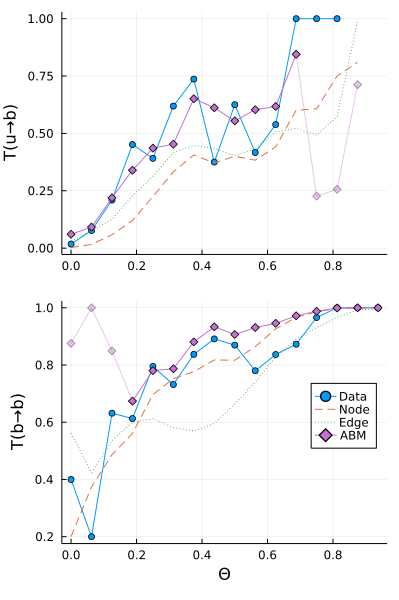

In [39]:
pall

## Different parameters. Best for manyT error metric. 

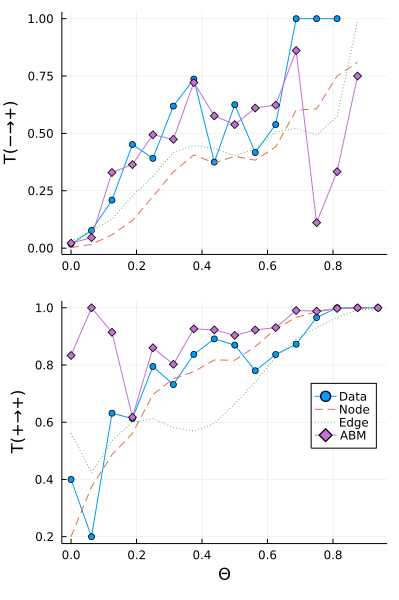

In [13]:
# parameters
pn = 0.4
pclose_triad = 0.
pr_pos = pr_neg = 0.15
padd = 0.09
threshold = [0:15...]/16

time_step = 90
time_ind = Int(time_step / 5)

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

xvals = real_trans_df.threshold
p1 = plot(xvals, real_trans_df.netsense_b2b, 
    markershape = :circle, label = "Data", legend = :right)#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_b2b, linestyle = :dash, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_b2b, linestyle = :dot, label = "Edge")#, linestyle = :none)
plot!(xvals, b2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)

# plot!([0.4, 0.7], [0.5, 0.8], markershape = :diamond, markersize = 2, label = "fff")
markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
xlabel!("Θ")
p2 = plot(legend = false)

plot!(xvals, real_trans_df.netsense_u2b, 
    markershape = :circle, label = "Data")#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_u2b, linestyle = :dash, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_u2b, linestyle = :dot, label = "Edge")#, linestyle = :none)
plot!(xvals, u2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)


ylabel!("T(−→+)")
Plots.scalefontsizes()
# Plots.scalefontsizes(1.3)

pall = plot(p2, p1, layout = (2,1), left_margins = 2mm)#, xtickfontsize=18,ytickfontsize=18,xguidefontsize=18,yguidefontsize=18, legendfontsize = 10,  thickness_scaling=1) 
plot!(windowsize = (400,600))
# plot!(margins = 2.0)


# title!("pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01")

# savefig(pall, "ABM_result.pdf")

# Calculating error for edge and node randomization

In [30]:
real_trans_df

mse = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(0.9327230755126914, 3.908759190827624, 0.8146233317693982, 3.1628818989844203)

In [31]:

mse = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(1.257523772472556, 4.379225839404921, 1.1650954074853879, 3.798715754039451)

Apart from the error for MSE the results for ABM give better approximation of the transition probabilities. 

## Triad balanced triads density

In [38]:
dicts

2940-element Vector{Dict{String, Float64}}:
 Dict("padd" => 0.01, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.03, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.05, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.07, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.09, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.01, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.03, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.05, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.07, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.09, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 ⋮
 Dict("padd" => 0.

In [ ]:
function plot_dict(dicts, df, param_ind)

    dict = dicts[results_df[param_ind, :dict_ind]]
    cropped_res = get_part_dataframe(res, dict)

    time_ind = Int(results_df[param_ind, :time_ind])
    xvals = cropped_res[:, :threshold]
    b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
    u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

    p1 = plot(xvals, b2b_vals, markershape = markers[1], label = "ABM T(+->+)")#, linestyle = :none)
    plot!(p1, xvals, u2b_vals, markershape = markers[2], label = "ABM T(-->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_b2b, markershape = markers[3], label = "Net T(+->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_u2b, markershape = markers[4], label = "Net T(-->+)")#, linestyle = :none)
    title!(p1, "steps="*string(10*time_ind))
    
    return p1
end

p1 = plot_dict(dicts, results_df, 665)
# title!(p1, string(dicts[results_df[665, :dict_ind]]))
display(string(dicts[results_df[665, :dict_ind]]))
p2 = plot_dict(dicts, results_df, 60)
display(string(dicts[results_df[60, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])
p3 = plot_dict(dicts, results_df, 1481)
display(string(dicts[results_df[1481, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])

plot!(p1, legend = :outertopright)
plot!(p1, legend = :outerbottom)
plot!(p2, legend = false)
plot!(p3, legend = false)

plot(p1, p2, p3, layout = (1,3))

## Influence of different pn values for specific theta

In [39]:
threshold = [5] / 16
# pn = [0.]

# parameters
# pn = [0.8]
# pclose_triad = unique(res.pclose_triad)
# pr_pos = pr_neg = unique(res.pr_pos)
# padd = unique(res.padd)
# threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict  threshold#padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

dict = dicts[1]

cropped_res = get_part_dataframe(res, dict; verbose =false)

nrow(cropped_res)

360

In [40]:
dict

Dict{String, Float64} with 1 entry:
  "threshold" => 0.3125

In [41]:
time_ind = time_inds[3]

27

In [42]:
cropped_res.b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
cropped_res.u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]];


In [43]:
using DataFrames, GLM

lm1 = fit(LinearModel, @formula(pn ~ b2b_vals), cropped_res)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

pn ~ 1 + b2b_vals

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  -1.46256    0.201277  -7.27    <1e-11   -1.8584    -1.06673
b2b_vals      2.28076    0.233167   9.78    <1e-19    1.82221    2.73931
────────────────────────────────────────────────────────────────────────

As expected, with small threshold pn is not important. With $\Theta=0.5$, it is very important. 

In [44]:
unique(res.pn)

6-element Vector{Union{Missing, Float64}}:
 0.0
 0.2
 0.4
 0.6
 0.8
 1.0